In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from helpers_new import PlotROCCurve

confidence_interval = 95
random_seed = 0
# Containers for all results
result_list = []

2025-05-31 15:32:26.506050: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
train_df = pd.read_csv("/u/scratch/x/xxiong/mimic-nlp-bench/train.csv")
test_df = pd.read_csv("/u/scratch/x/xxiong/mimic-nlp-bench/test.csv")

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")


Train shape: (353150, 893)
Test shape: (88287, 893)


In [3]:
note_cols = [f"note_embed_{i}" for i in range(768)]
structured_cols = [
    'age', 'gender', 'triage_temperature', 'triage_heartrate', 'triage_resprate',
    'triage_o2sat', 'triage_sbp', 'triage_dbp', 'triage_pain', 'triage_acuity',
    'triage_MAP', 'score_CCI', 'score_CART', 'score_REMS', 'score_NEWS',
    'score_NEWS2', 'score_MEWS'
]
all_features = structured_cols + note_cols
label_col = "outcome_hospitalization"  

In [4]:
X_train = train_df[all_features].fillna(0)
y_train = train_df[label_col]
X_test = test_df[all_features].fillna(0)
y_test = test_df[label_col]

In [5]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Logistic Regression:


Training time: 17.184855222702026 seconds
AUC: 0.9294678392838841
AUPRC: 0.9417847137694959
Sensitivity: 0.8340149721365191
Specificity: 0.867695154488338
Score thresold: 0.3143792027835985
2.5 97.5


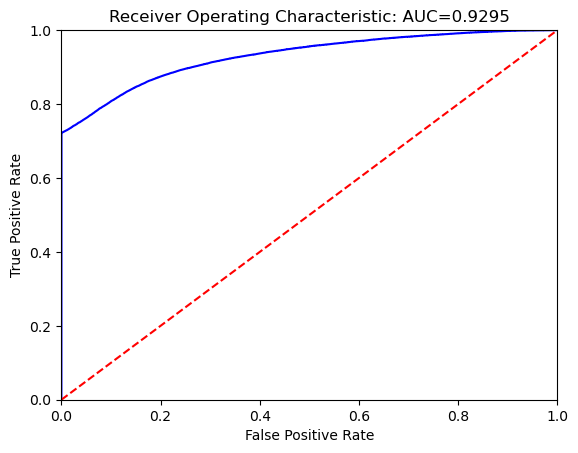

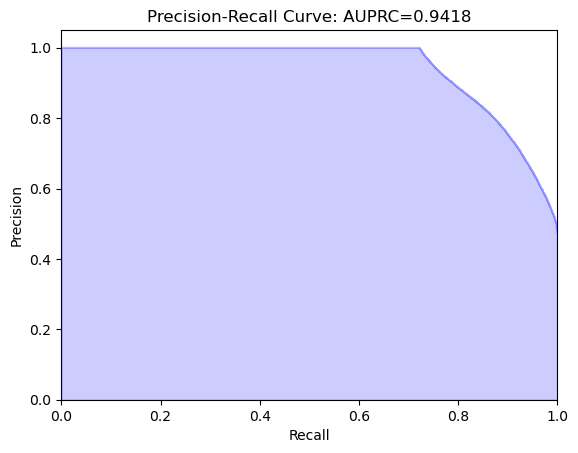

In [6]:
from sklearn.linear_model import LogisticRegression
import time

print("Logistic Regression:")
log_model = LogisticRegression(max_iter=1000, random_state=random_seed)
start = time.time()
log_model.fit(X_train, y_train)
runtime = time.time() - start
print("Training time:", runtime, "seconds")

probs = log_model.predict_proba(X_test)[:, 1]

# use PlotROCCurve
result = PlotROCCurve(probs, y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [7]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

mlp = MLP(X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

for epoch in range(10):
    mlp.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = mlp(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
runtime = time.time() - start
print("Training time:", runtime, "seconds")


Epoch 1, Loss: 1635.3696


Epoch 2, Loss: 1611.6450


Epoch 3, Loss: 1604.8752


Epoch 4, Loss: 1601.8242


Epoch 5, Loss: 1599.6882


Epoch 6, Loss: 1599.1114


Epoch 7, Loss: 1599.8157


Epoch 8, Loss: 1598.0899


Epoch 9, Loss: 1598.1510


Epoch 10, Loss: 1598.0796
Training time: 168.0476038455963 seconds


AUC: 0.930936157882377
AUPRC: 0.9394569061214451
Sensitivity: 0.8319580971514673
Specificity: 0.8743652637920647
Score thresold: 0.32471344
2.5 97.5


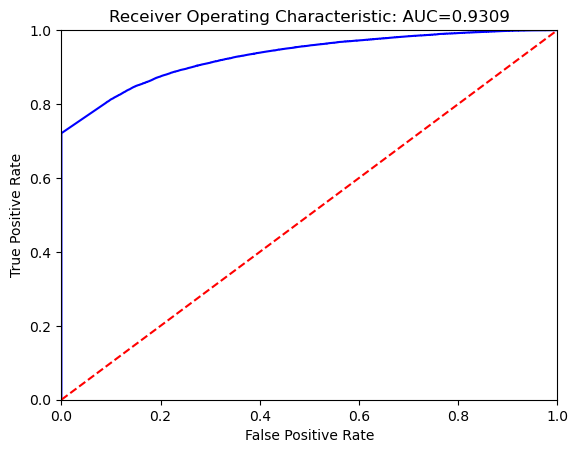

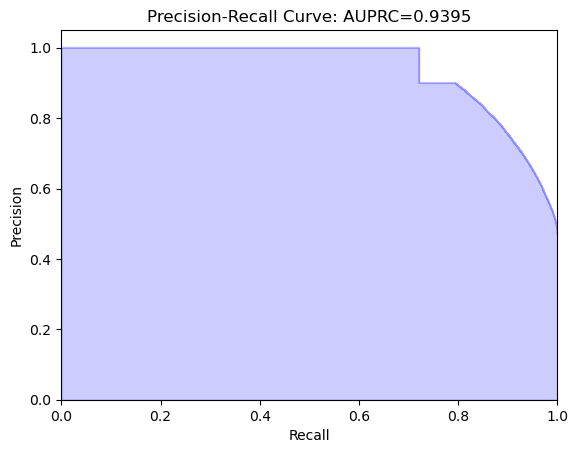

In [9]:
mlp.eval()
with torch.no_grad():
    y_prob_mlp = mlp(X_test_tensor.to(device)).cpu().numpy().flatten()

result = PlotROCCurve(y_prob_mlp, y_test, ci=confidence_interval, random_seed=random_seed)

results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [10]:
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 
                                               'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 
                                               'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 
                                               'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join('/u/scratch/x/xxiong/mimic-nlp-bench/results', 'result_critical_triage.csv'), index=False)

result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join('/u/scratch/x/xxiong/mimic-nlp-bench/results', 'task2.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.314,0.929 (0.928-0.931),0.942 (0.941-0.943),0.834 (0.825-0.837),0.868 (0.866-0.88),17.185
1,MLP,0.325,0.931 (0.93-0.932),0.939 (0.938-0.94),0.832 (0.824-0.837),0.874 (0.868-0.887),168.048
